#### Notebook 4 - Addressing the questions
Streaming of high hype sport events (particularly football matches) is creating some additional stress on network capacity.
Topic became even more of interest when a pure internet broadcaster acquired the right for serie A matches for next season. 
The project is about some numerical investigation on the relationship between traffic growth on a mobile network in Italy and the scheduling of football matches involving italian teams. Specifically, investigation will address the following questions:

- Can we identify a significative numerical correlation between mobile traffic peaks and footbal matches schedule?
- If yes, can we add insigth for classes of football event parameters showing higher correlations (e.g. number of contemporary matches, hype of a single match, types of broadcaster)? 
- Can the information above be used to tune traffic growth forecasts on a mobile network?

The activity is intended as an investigation exercise, so data actually used, though obtained from real measurement, will first be normalized to range between artificially set bounds. 

#### Datasets

The notebook will leverage on following data:

- Some real traffic measurement from a mobile network on a generic geographical area in Italy over about 2 years. Data are normalized in a way that reduces all used kpi to range between 1 and 2. Only normalized and region wide values are shown.
- Scheduling of major footbal competitions involving italian teams (I considered 'Serie A' and 'Champions League')
- Information about the broadcaster distribuiting the matches (internet only or pay tv+internet)

#### Notebook organization
Activity is organized into different jupyter notebooks:
- The first notebook  is about preparing reading traffic data and adding normalization. As actual starting data will not be shared, this notebook is only intended for reference
- The second notebook will analize and prepare normalized data for actual usage 
- Third notebook reads, manipulates and prepare sport events dataframe
- Fourth notebook (the present one) merges all collected and preprocessed data and investigate relationship to try to answer the target questions

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import cufflinks as cf
%matplotlib inline

First, we read and merge the two dataframes prepared in other notebooks

In [556]:
Nw_Df=pd.read_csv('C:\\Users\\rpaglin\\OneDrive - Vodafone Group\\Desktop\\Nanodegree prj1 data\\nw_df.csv')

In [557]:
Hype_Df=pd.read_csv('C:\\Users\\rpaglin\\OneDrive - Vodafone Group\\Desktop\\Nanodegree prj1 data\\HypeDf.csv')

In [558]:
Nw_Df['DATE']=Nw_Df['DATE'].apply(lambda x: pd.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))

In [559]:
Nw_Df=Nw_Df.set_index(['DATE','TIME'])

In [560]:
Hype_Df['DATE']=Hype_Df['DATE'].apply(lambda x: pd.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))

In [561]:
Hype_Df=Hype_Df.set_index(['DATE','TIME'])

In [562]:
Hype_Df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1787 entries, (2018-08-18 00:00:00, 18) to (2021-05-23 00:00:00, 22)
Data columns (total 3 columns):
ChampionsLeague    1787 non-null float64
Hype               1787 non-null int64
SerieA             1787 non-null float64
dtypes: float64(2), int64(1)
memory usage: 50.4 KB


In [563]:
Nw_Df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20827 entries, (2019-01-01 00:00:00, 0) to (2021-05-28 00:00:00, 14)
Data columns (total 2 columns):
Thr (Norm)     20827 non-null float64
Conn (Norm)    20827 non-null float64
dtypes: float64(2)
memory usage: 393.6 KB


In [564]:
df=pd.concat([Nw_Df,Hype_Df],axis=1)

In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21129 entries, (2018-08-18 00:00:00, 18) to (2021-05-28 00:00:00, 14)
Data columns (total 5 columns):
Thr (Norm)         20827 non-null float64
Conn (Norm)        20827 non-null float64
ChampionsLeague    1787 non-null float64
Hype               1787 non-null float64
SerieA             1787 non-null float64
dtypes: float64(5)
memory usage: 894.9 KB


Then we manage Nan generated from the merge:
- we insert 0 in the footbal matches info for rows without matches and with network measurements
- we drop the lines with matches but no network measures

In [566]:
df.tail()

Thr (Norm)  Conn (Norm)  ChampionsLeague  Hype  SerieA
DATE       TIME                                                        
2021-05-28 10      1.349436     2.003036              NaN   NaN     NaN
           11      1.397872     2.005011              NaN   NaN     NaN
           12      1.507205     1.992988              NaN   NaN     NaN
           13      1.598983     1.976059              NaN   NaN     NaN
           14      1.694435     1.971523              NaN   NaN     NaN

In [567]:
df['ChampionsLeague'].fillna(0,inplace=True)
df['SerieA'].fillna(0,inplace=True)
df['Hype'].fillna(0,inplace=True)

In [568]:
df.tail(10)

Thr (Norm)  Conn (Norm)  ChampionsLeague  Hype  SerieA
DATE       TIME                                                        
2021-05-28 5       0.516417     1.604000              0.0   0.0     0.0
           6       0.714319     1.659888              0.0   0.0     0.0
           7       1.017623     1.788548              0.0   0.0     0.0
           8       1.192673     1.915676              0.0   0.0     0.0
           9       1.295367     1.978635              0.0   0.0     0.0
           10      1.349436     2.003036              0.0   0.0     0.0
           11      1.397872     2.005011              0.0   0.0     0.0
           12      1.507205     1.992988              0.0   0.0     0.0
           13      1.598983     1.976059              0.0   0.0     0.0
           14      1.694435     1.971523              0.0   0.0     0.0

In [569]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21129 entries, (2018-08-18 00:00:00, 18) to (2021-05-28 00:00:00, 14)
Data columns (total 5 columns):
Thr (Norm)         20827 non-null float64
Conn (Norm)        20827 non-null float64
ChampionsLeague    21129 non-null float64
Hype               21129 non-null float64
SerieA             21129 non-null float64
dtypes: float64(5)
memory usage: 894.9 KB


In [570]:
df=df.dropna(axis=0)

In [571]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20827 entries, (2019-01-01 00:00:00, 0) to (2021-05-28 00:00:00, 14)
Data columns (total 5 columns):
Thr (Norm)         20827 non-null float64
Conn (Norm)        20827 non-null float64
ChampionsLeague    20827 non-null float64
Hype               20827 non-null float64
SerieA             20827 non-null float64
dtypes: float64(5)
memory usage: 882.2 KB


At this point all relevant data are in a single df and we don't have more Nan value.
Let's check the content of the DF in a sunday with SerieA matches:

In [572]:
df.loc[pd.datetime(2021, 3, 7)] #a sunday with matches

,Thr (Norm),Conn (Norm),ChampionsLeague,Hype,SerieA
TIME,,,,,
0,1.403261,1.651505,0.0,0.0,0.0
1,1.017881,1.609515,0.0,0.0,0.0
2,0.769966,1.584168,0.0,0.0,0.0
3,0.584770,1.566506,0.0,0.0,0.0
4,0.489827,1.558430,0.0,0.0,0.0
5,0.469985,1.557944,0.0,0.0,0.0
6,0.536909,1.570746,0.0,0.0,0.0
7,0.759818,1.610016,0.0,0.0,0.0
8,1.069868,1.684940,0.0,0.0,0.0


As expected, 6 Serie A matches are visible in the outcome, 1 started around Midday, 3 around 6pm 1 at 6pm anf the last at 9pm.  
Now that data are ready we can start addressing the questions. First 1 is:

#### Question 1: Can we identify a significative numerical correlation between mobile traffic peaks and footbal matches schedule?

Let's start from correlation matrices. We consider correlation both on the whole dataframe and on a dataframe only considering daily peak figures

In [573]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Thr (Norm),Conn (Norm),ChampionsLeague,Hype,SerieA
Thr (Norm),1,0.704787,0.0806945,0.23464,0.215682
Conn (Norm),0.704787,1,0.0130583,0.0698841,0.0677966
ChampionsLeague,0.0806945,0.0130583,1,0.149751,-0.0143477
Hype,0.23464,0.0698841,0.149751,1,0.971045
SerieA,0.215682,0.0677966,-0.0143477,0.971045,1


In [574]:
#Grouping to have daily max
corr = df.groupby('DATE').max().corr()
corr.style.background_gradient(cmap='coolwarm')

,Thr (Norm),Conn (Norm),ChampionsLeague,Hype,SerieA
Thr (Norm),1,0.969101,0.0545621,0.162409,0.149262
Conn (Norm),0.969101,1,0.0393025,0.0875547,0.0806997
ChampionsLeague,0.0545621,0.0393025,1,0.0836413,-0.101828
Hype,0.162409,0.0875547,0.0836413,1,0.968771
SerieA,0.149262,0.0806997,-0.101828,0.968771,1


Looking at relation between traffic measurement (firts two rows) and match schedule (last three column) the correlation is positive but appear to be rather low. Let's limit the analysy to daily peaks (the actual case of interest) for which correlation appear to be a bit higher: 

In [575]:
df_dp=df.groupby('DATE').max()

Then, let's plot a few plot trying to investigate hype versus throughput relation: 

In [576]:
fig=df_dp.iplot(x='Hype',y='Thr (Norm)',asFigure=True,xTitle='Hype',yTitle='Normalized throughput', mode='markers')
fig.show()

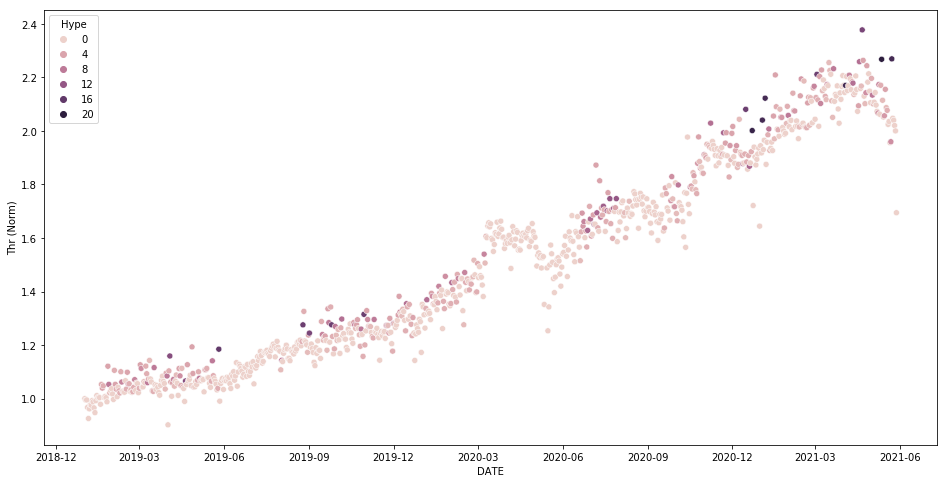

In [577]:
plt.figure(figsize=(16,8))
fig=sns.scatterplot(data=df_dp.reset_index(), x='DATE', y='Thr (Norm)', hue='Hype')


Some general outcome from correlation  and plots observation:
- Overall, traffic growth is relatively independent from football match es schedule (and I guess from other sport or high hype event). In the graph we see an organic and consistent growth (apparently not far from a linear trend) throught the whole period for which data are available. This organic growth (maybe motivated be new users or by increased traffic per user, or even possibly by limits in the statistical quality of source data after normalization), appear to be the most significative trend in network traffic calculation.
- Nevertheless, high hype events in the scatter plot are mostly positioned on the upper part of the scale per each period. A forecast mainly based on time slot with footbal hyped events may provide a conservative and more effective estimations of resources actually needed 

#### Question 2: 
Can we add insigth for classes of football event parameters showing higher correlations (e.g. number of contemporary matches, hype of a single match, types of broadcaster)?

#### Tentative answer, based on evidence above:

In the mapping of categorical values about football schedules into numerical variables, we defined three different variables on each hour in the considered period:
    - The number of Serie A matches live in the hour
    - The number of Champions League matches live in the hour
    - An ad hoc 'hype' functions, where hype of a match is measured by the presence among the opposing teams of one or two major  SerieA teams
    
Considering correlation matrices discussed above, the variables that is more effective in impacting overal throughput is the 'hype' of the match, while number of contemporary matches appear to play a less significant role (we can say due to the fact that major matches are normally not broadcasted at the same time)

#### Question 3: Linear regression for traffic forecast. 

Let's first look at a linear regression plot based on pure traffic data (daily peaks only):

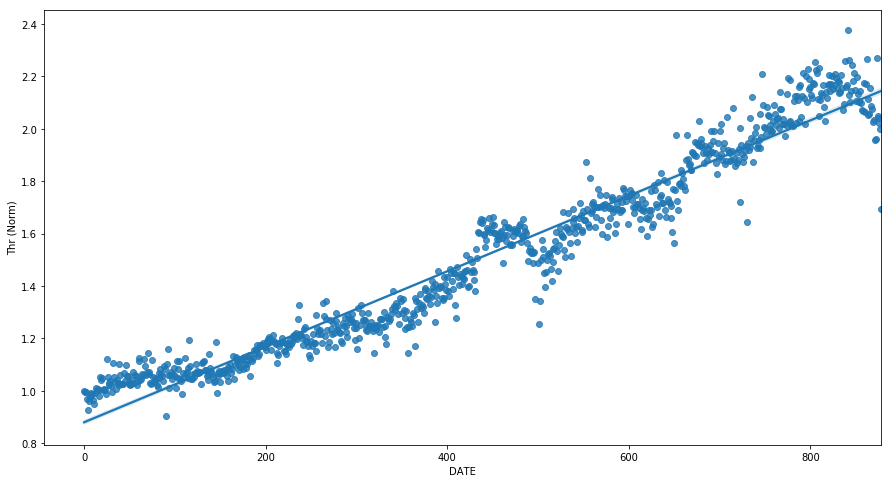

In [524]:
plt.figure(figsize=(15,8))
regplot_df=df_dp.reset_index()
x0=regplot_df['DATE'][0].value
regplot_df['DATE']=regplot_df['DATE'].apply(lambda x: (x.value-x0)/(3600*24*1e9))
fig=sns.regplot(data=regplot_df, x='DATE', y='Thr (Norm)')

The above regression plot (uniquely based on one variable) appears effective in capturing the organic growth trend but probably weak in capuring peaks that shall be manged in the network. Considering what said before, let's see if a similar plot based on 'Hyped' hours only is more effective in being near the peaks: 

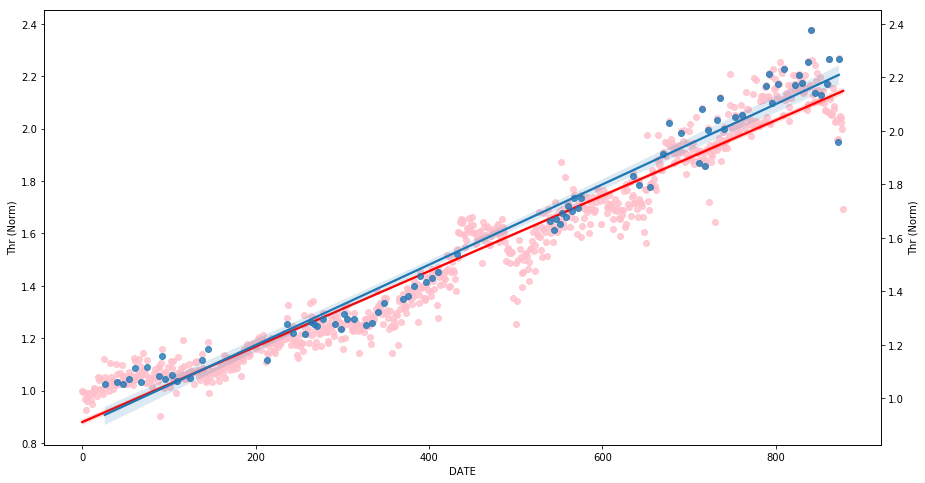

In [578]:
fig, ax = plt.subplots()
ax2 = ax.twinx() 
fig.set_size_inches(15,8)
#Red line and pink scatter show the linear regression graph presented above 
sns.regplot(data=regplot_df, x='DATE', y='Thr (Norm)', scatter_kws={"color": "pink"}, line_kws={"color": "red"},ax=ax)
#Blue line and scatter on the same graph show the linear regression line based on hyped data only 
sns.regplot(data=regplot_df[regplot_df['Hype']>5], x='DATE', y='Thr (Norm)', ax=ax2)

As expected the regression plot based on 'hyped' hour is somehow more aggressive in the forecast (and probably more effective in calculating needed network capacity). However, even in this case, several measurements are over the forecast. 

At the end, let's make the exercise of linear regression forecast. We will try two cases, with data traffic only first and then with sport event info included

Let's start without:

In [579]:
df_dp_linregr=df_dp.reset_index()
df_dp_linregr['DATE']=df_dp_linregr['DATE'].apply(lambda x: x.value/(3600*24*1e9))
df_dp_linregr.info()
X_train, X_test, y_train, y_test = train_test_split(df_dp_linregr[['DATE','Conn (Norm)']], df_dp_linregr['Thr (Norm)'], test_size = .30, random_state=42) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 6 columns):
DATE               877 non-null float64
Thr (Norm)         877 non-null float64
Conn (Norm)        877 non-null float64
ChampionsLeague    877 non-null float64
Hype               877 non-null float64
SerieA             877 non-null float64
dtypes: float64(6)
memory usage: 41.2 KB


In [580]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [581]:
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.9534558287554198 on 264 values.'

Now that we have a prediction, let's plot the outcome of the prediction against actual values:

Text(0,0.5,'Throughput')

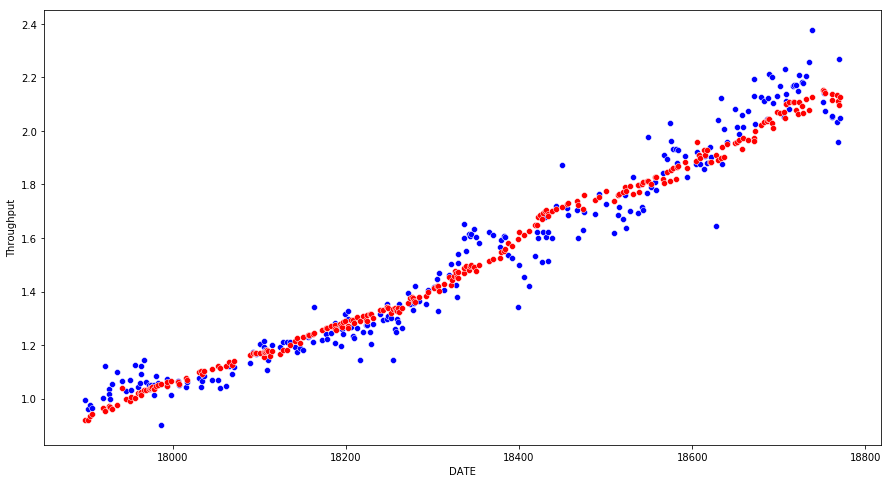

In [529]:
test_outcome=X_test
test_outcome['Actual Thr']=y_test
test_outcome['Predicted Thr']=y_test_preds
test_outcome.sort_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.scatterplot(data=test_outcome, x='DATE',y='Actual Thr',  color = 'blue' )
sns.scatterplot(data=test_outcome, x='DATE',y='Predicted Thr', color='red')
ax.set_ylabel("Throughput")

Finally, let's repeat the exercise using 'hype' column

In [530]:
df_dp_linregr=df_dp.reset_index()
df_dp_linregr['DATE']=df_dp_linregr['DATE'].apply(lambda x: x.value/(3600*24*1e9))
df_dp_linregr.info()
X_train, X_test, y_train, y_test = train_test_split(df_dp_linregr[['DATE','Conn (Norm)','Hype']], df_dp_linregr['Thr (Norm)'], test_size = .30, random_state=42) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 6 columns):
DATE               877 non-null float64
Thr (Norm)         877 non-null float64
Conn (Norm)        877 non-null float64
ChampionsLeague    877 non-null float64
Hype               877 non-null float64
SerieA             877 non-null float64
dtypes: float64(6)
memory usage: 41.2 KB


In [531]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [532]:
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for your model was 0.9611264481182126 on 264 values.'

Now that we have a prediction, let's plot the outcome of the prediction againsta ctual values:

Text(0,0.5,'Throughput')

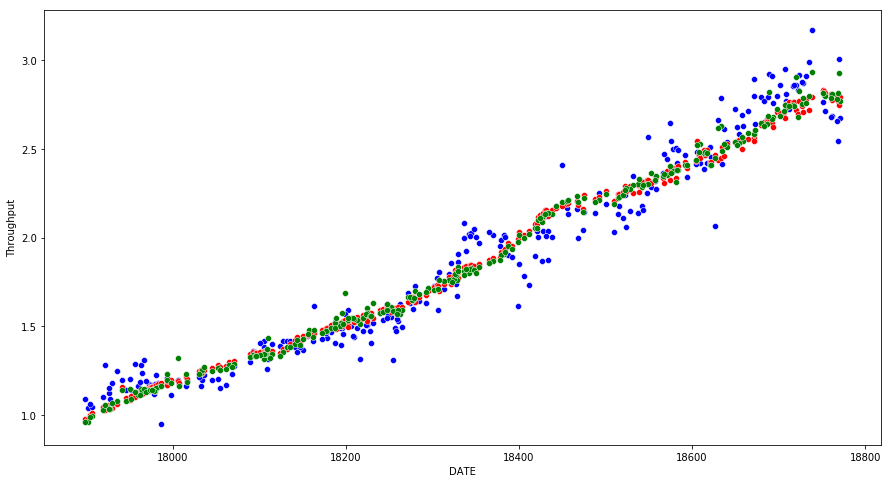

In [500]:
test_outcome_with_hype=X_test
test_outcome_with_hype['Actual Thr']=y_test
test_outcome_with_hype['Predicted Thr']=y_test_preds
test_outcome.sort_index(inplace=True)
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
sns.scatterplot(data=test_outcome_with_hype, x='DATE',y='Actual Thr',  color = 'blue' )
sns.scatterplot(data=test_outcome, x='DATE',y='Predicted Thr', color='red')
sns.scatterplot(data=test_outcome_with_hype, x='DATE',y='Predicted Thr', color='green')
ax.set_ylabel("Throughput")


Again, the forecast also using sport event data appear to be a bit more effective (at least on this single picture) to predict period with very high throughput. For any other aspect, the usage of sport event data doesn't improve significatevely the quality of the linear regression, that is pretty fitting in both cases.

#### Conclusions
As described in the beginning, the analysis is intended as a procedural exercise and include a few sources of weakness:
- To avoid disclosure of information, used traffic data were related to a limitedgeographical area; 
- For the same reason, data were normalized before usage to vary in a predefined range (roughly for 1 to 2).
- Analysis of the results was limited to some initial evidences and hints for sake of time 

Bearing in mind the limitation above, we can try to draft the following conclusions for the exercise:
- Traffic growth in the network is mainly driven by organic growth (additional users and or growth of traffic per user. Sport events can carry to occasional peaks that are however soon reached by the normal traffic levels
- Usage of sport events information does not carry particolar benefit in modeling the main trend (organic growth) but might results in a more conservative network dimensioning given some ability to anticipate occasional peaks.
- Among footbal events parameter, the one providing the greatest correlation is the presence of major italian teams in the ongoing match, more than the number of conteporary matchs  
